# Model 1

### Target:

- Get the set-up right   
- Set Transforms  
- Set Data Loader  
- Set Basic Working Code   
- Set Basic Training  & Test Loop   

### Results:

- Parameters : 6.3M
- Best Training Accuracy : 99.92
- Best Test Accuracy : 99.30

### Analysis:

- Extremely Heavy Model for such a problem
- Model is over-fitting, but we are changing our model approaches in the next few step

# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
from utils import load_mnist_data

In [4]:
train , test = load_mnist_data(train_transforms,test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

C:\Users\Tharun\anaconda3\envs\pytorch\lib\site-packages\torchvision\datasets\mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


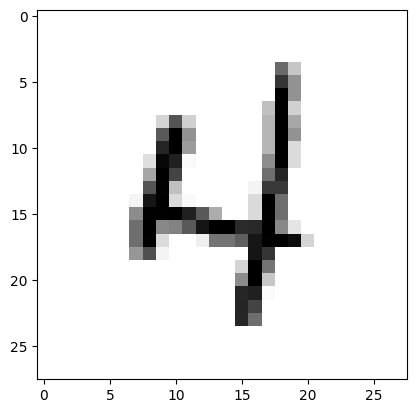

In [6]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

In [7]:
from utils import plot_images

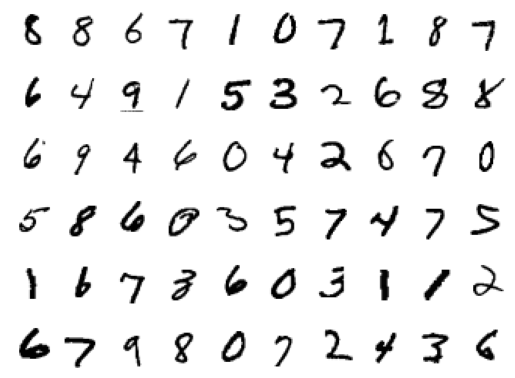

In [8]:
plot_images(images)

# How did we get those mean and std values which we used above?

Let's run a small experiment

In [9]:
# simple transform
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                      #  transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


# The model

Let's start with the basic model we first structured

In [10]:
from model import Model1 as Net

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [11]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 64, 28, 28]          18,496
         MaxPool2d-3           [-1, 64, 14, 14]               0
            Conv2d-4          [-1, 128, 14, 14]          73,856
            Conv2d-5          [-1, 256, 14, 14]         295,168
         MaxPool2d-6            [-1, 256, 7, 7]               0
            Conv2d-7            [-1, 512, 5, 5]       1,180,160
            Conv2d-8           [-1, 1024, 3, 3]       4,719,616
            Conv2d-9             [-1, 10, 1, 1]          92,170
Total params: 6,379,786
Trainable params: 6,379,786
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.51
Params size (MB): 24.34
Estimated Total Size (MB): 25.85
--------------------------------

# Training and Testing

All right, so we have 6.3M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments.

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions and keep them as python scripts in `model.py`

In [12]:
from model import train,test

# Let's Train and test our model

In [13]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15

train_losses = []
test_losses = []
train_acc = []
test_acc = []

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch , train_losses , train_acc)
    test(model, device, test_loader ,test_losses , test_acc)

EPOCH: 0


Loss=0.052589256316423416 Batch_id=468 Accuracy=88.10: 100%|█████████████████████████| 469/469 [00:15<00:00, 31.02it/s]



Test set: Average loss: 0.0628, Accuracy: 9794/10000 (97.94%)

EPOCH: 1


Loss=0.021785372868180275 Batch_id=468 Accuracy=98.41: 100%|█████████████████████████| 469/469 [00:14<00:00, 32.37it/s]



Test set: Average loss: 0.0352, Accuracy: 9877/10000 (98.77%)

EPOCH: 2


Loss=0.059224683791399 Batch_id=468 Accuracy=98.92: 100%|████████████████████████████| 469/469 [00:14<00:00, 32.32it/s]



Test set: Average loss: 0.0335, Accuracy: 9884/10000 (98.84%)

EPOCH: 3


Loss=0.005361540243029594 Batch_id=468 Accuracy=99.21: 100%|█████████████████████████| 469/469 [00:14<00:00, 32.16it/s]



Test set: Average loss: 0.0282, Accuracy: 9907/10000 (99.07%)

EPOCH: 4


Loss=0.010334362275898457 Batch_id=468 Accuracy=99.46: 100%|█████████████████████████| 469/469 [00:14<00:00, 32.11it/s]



Test set: Average loss: 0.0274, Accuracy: 9907/10000 (99.07%)

EPOCH: 5


Loss=0.003959272988140583 Batch_id=468 Accuracy=99.55: 100%|█████████████████████████| 469/469 [00:14<00:00, 32.14it/s]



Test set: Average loss: 0.0267, Accuracy: 9910/10000 (99.10%)

EPOCH: 6


Loss=0.03917032107710838 Batch_id=468 Accuracy=99.67: 100%|██████████████████████████| 469/469 [00:14<00:00, 32.12it/s]



Test set: Average loss: 0.0289, Accuracy: 9913/10000 (99.13%)

EPOCH: 7


Loss=0.013953231275081635 Batch_id=468 Accuracy=99.75: 100%|█████████████████████████| 469/469 [00:14<00:00, 32.05it/s]



Test set: Average loss: 0.0274, Accuracy: 9922/10000 (99.22%)

EPOCH: 8


Loss=0.004748695995658636 Batch_id=468 Accuracy=99.75: 100%|█████████████████████████| 469/469 [00:14<00:00, 32.08it/s]



Test set: Average loss: 0.0277, Accuracy: 9921/10000 (99.21%)

EPOCH: 9


Loss=0.00027146769571118057 Batch_id=468 Accuracy=99.84: 100%|███████████████████████| 469/469 [00:14<00:00, 32.04it/s]



Test set: Average loss: 0.0298, Accuracy: 9924/10000 (99.24%)

EPOCH: 10


Loss=0.0025867256335914135 Batch_id=468 Accuracy=99.86: 100%|████████████████████████| 469/469 [00:14<00:00, 32.15it/s]



Test set: Average loss: 0.0270, Accuracy: 9927/10000 (99.27%)

EPOCH: 11


Loss=0.0005140866851434112 Batch_id=468 Accuracy=99.88: 100%|████████████████████████| 469/469 [00:14<00:00, 32.00it/s]



Test set: Average loss: 0.0375, Accuracy: 9907/10000 (99.07%)

EPOCH: 12


Loss=0.00012997206067666411 Batch_id=468 Accuracy=99.90: 100%|███████████████████████| 469/469 [00:14<00:00, 31.98it/s]



Test set: Average loss: 0.0295, Accuracy: 9930/10000 (99.30%)

EPOCH: 13


Loss=0.01350824162364006 Batch_id=468 Accuracy=99.92: 100%|██████████████████████████| 469/469 [00:14<00:00, 31.66it/s]



Test set: Average loss: 0.0408, Accuracy: 9919/10000 (99.19%)

EPOCH: 14


Loss=0.00019132871238980442 Batch_id=468 Accuracy=99.87: 100%|███████████████████████| 469/469 [00:14<00:00, 31.94it/s]



Test set: Average loss: 0.0318, Accuracy: 9915/10000 (99.15%)



In [14]:
from model import plot_graphs

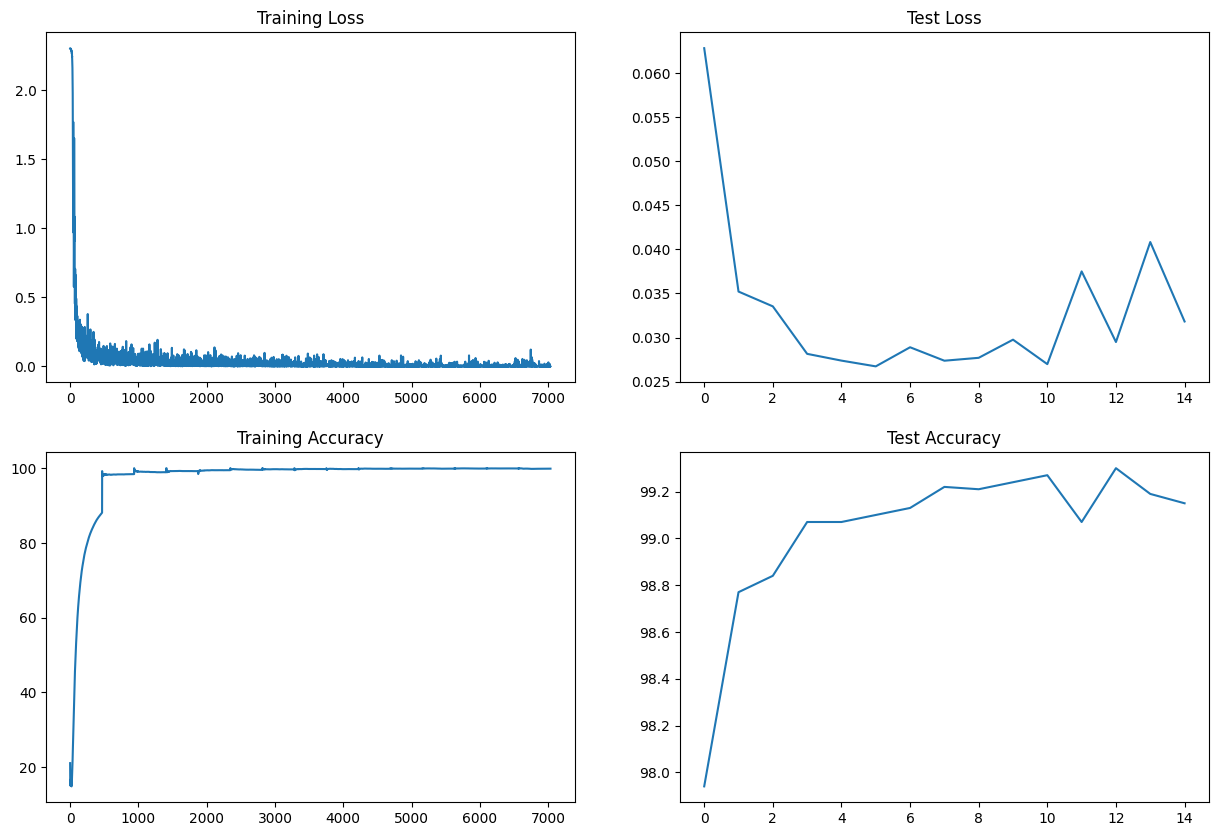

In [15]:
plot_graphs(train_losses , train_acc , test_losses , test_acc)